In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [11]:
# define your paths here
x_train_path = '../data/raw/train/diabetes-features-train.csv'
y_train_path = '../data/raw/train/diabetes-labels-train.csv'
x_test_path = '../data/raw/test/diabetes-features-test.csv'
x_val_path = '../data/raw/validation/diabetes-features-validation.csv'

In [12]:
# load all the available files

X_train = pd.read_csv(x_train_path, index_col=0)
y_train = pd.read_csv(y_train_path, index_col=0)
X_test = pd.read_csv(x_test_path, index_col=0)
X_val = pd.read_csv(x_val_path, index_col=0)


In [13]:
# Identifying Categorical and Continous Variables
print(X_train.columns)

# Sample of rows to inspect patterns
print(X_train.head())

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
   HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0        1.0  27.20     0.0     0.0                   0.0   
1     0.0       0.0        1.0  36.61     0.0     0.0                   0.0   
2     1.0       0.0        1.0  24.19     1.0     0.0                   0.0   
3     1.0       0.0        1.0  34.33     0.0     0.0                   0.0   
4     0.0       NaN        0.0  22.81     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0           1.0     0.0      0.0  ...            1.0          0.0      3.0   
1           1.0     1.0      1.0  ...            1.

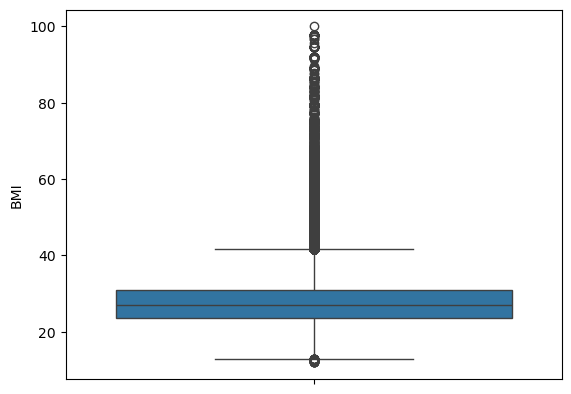

In [14]:
#View Outliers in BMI 
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(X_train['BMI'])
plt.show()


In [15]:
# Calculate Q1, Q3, and IQR for BMI
Q1 = X_train['BMI'].quantile(0.25)
Q3 = X_train['BMI'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")


Lower Bound: 12.975000000000003, Upper Bound: 41.654999999999994


In [16]:
# Checking the highest and lowest values in the BMI column
highest_bmi = X_train['BMI'].max()
lowest_bmi = X_train['BMI'].min()
missing_bmi = X_train['BMI'].isnull().sum()

print(f"Highest BMI: {highest_bmi}")
print(f"Lowest BMI: {lowest_bmi}")
print(f"Number of Missing BMI: {missing_bmi}")


Highest BMI: 99.95
Lowest BMI: 12.02
Number of Missing BMI: 27408


In [19]:

# Categorize BMI into ranges
bmi_ranges = pd.cut(
    X_train["BMI"],
    bins=[0, 18.5, 25, 30, 40, 50, 100],
    labels=["Underweight", "Normal", "Overweight", "Obese (Class 1-2)", "Severely Obese", "Extremely Obese"],
    include_lowest=True,
)

# Count the number of samples in each BMI range
bmi_distribution = bmi_ranges.value_counts().reset_index()
bmi_distribution.columns = ["BMI Range", "Count"]

# Display the results
print(bmi_distribution)


           BMI Range   Count
0         Overweight  110690
1             Normal   99613
2  Obese (Class 1-2)   76159
3     Severely Obese   11389
4        Underweight    5067
5    Extremely Obese    2810


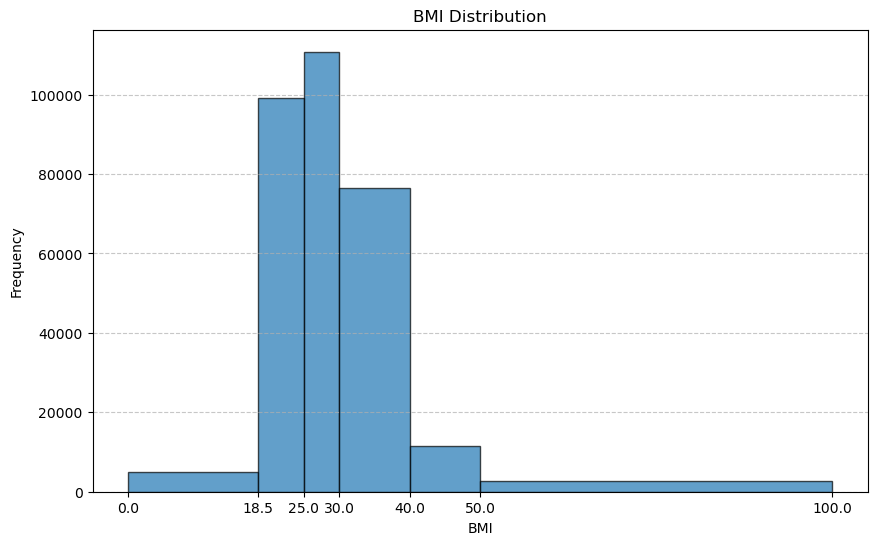

In [20]:


# Plot histogram for BMI distribution
plt.figure(figsize=(10, 6))
X_train['BMI'].plot(kind='hist', bins=[0, 18.5, 25, 30, 40, 50, 100], edgecolor='black', alpha=0.7)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.xticks([0, 18.5, 25, 30, 40, 50, 100])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:

# Log-transform BMI in the training dataset
X_train['BMI'] = np.log1p(X_train['BMI'])  # log1p ensures numerical stability for small values

# Log-transform BMI in the validation dataset
X_val['BMI'] = np.log1p(X_val['BMI'])

# Log-transform BMI in the test dataset
X_test['BMI'] = np.log1p(X_test['BMI'])


In [22]:
# Combine X_train and y_train
X_train['Diabetes_binary'] = y_train

# Separate by class
class_0_data = X_train[X_train['Diabetes_binary'] == 0]
class_1_data = X_train[X_train['Diabetes_binary'] == 1]

# Process class 0: Drop rows with missing values
class_0_data_clean = class_0_data.dropna()

# Process class 1: Impute missing values
# Numerical columns
numerical_cols = ['BMI']  # Replace with actual numerical columns
for col in numerical_cols:
    class_1_data.loc[:, col] = class_1_data[col].fillna(class_1_data[col].median())


# Categorical columns
categorical_cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 
                    'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 
                    'Education', 'Income']
  # Replace with actual categorical columns
for col in categorical_cols:
    class_1_data.loc[:, col] = class_1_data[col].fillna(class_1_data[col].mode()[0])

# Recombine processed data
processed_data = pd.concat([class_0_data_clean, class_1_data])

# Separate X_train and y_train
X_train_processed = processed_data.drop(columns=['Diabetes_binary'])
y_train_processed = processed_data['Diabetes_binary']


In [23]:
print(y_train_processed.value_counts())


Diabetes_binary
0.0    164976
1.0     43530
Name: count, dtype: int64


In [24]:
# Confim if missing values are present
X_train_processed.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [25]:


# Define the processed folder path based on current working directory
if os.getcwd().endswith('notebook'):  # If running from the 'notebook/' folder
    processed_folder = os.path.join('..', 'data', 'processed')
else:  # If running from the project root
    processed_folder = os.path.join('data', 'processed')

# Ensure the folder exists
if not os.path.exists(processed_folder):
    os.makedirs(processed_folder)

# Save files
X_train_processed.to_csv(os.path.join(processed_folder, 'X_train_imputed.csv'), index=False)
X_val.to_csv(os.path.join(processed_folder, 'X_val_log.csv'), index=False)
X_test.to_csv(os.path.join(processed_folder, 'X_test_log.csv'), index=False)
y_train_processed.to_csv(os.path.join(processed_folder, 'y_train.csv'), index=False)


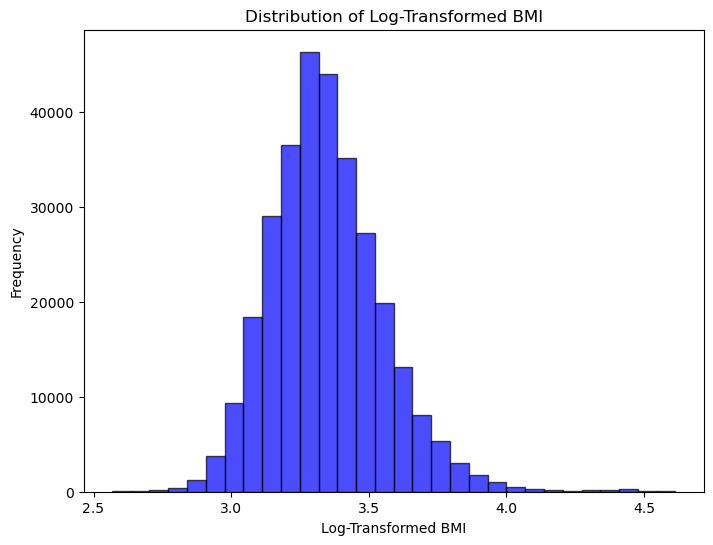

In [26]:
import matplotlib.pyplot as plt

# Plot histogram of log-transformed BMI
plt.figure(figsize=(8, 6))
plt.hist(X_train['BMI'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Log-Transformed BMI")
plt.xlabel("Log-Transformed BMI")
plt.ylabel("Frequency")
plt.show()
